# PyCIEMSS optimize interface with different intervention types

### Load dependencies and interfaces

In [7]:
import os
import time
from typing import Dict, List

import numpy as np
import pyro
import torch

import pyciemss
import pyciemss.visuals.plots as plots
from pyciemss.integration_utils.intervention_builder import (
    combine_static_parameter_interventions,
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
    intervention_func_combinator,
)
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi
from copy import deepcopy

smoke_test = "CI" in os.environ

### Select model

In [8]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [9]:
start_time = 0.0
end_time_SIR = 40.0
end_time_SEIRHD = 60.0
end_time_SEIRHD2 = 90.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 1000
num_samples_ouu = 10 if smoke_test else 1000 # controls accuracy of risk estimation in each optimization iteration
maxiter = 0 if smoke_test else 3    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 1 if smoke_test else 30  # maximum number of function evaluations in each instance of local convex optimization

### Baseline samples before optimization from model 1 (SIR)

Time taken:  2.329202890396118
Risk associated with QoI: [480.3737524414062]


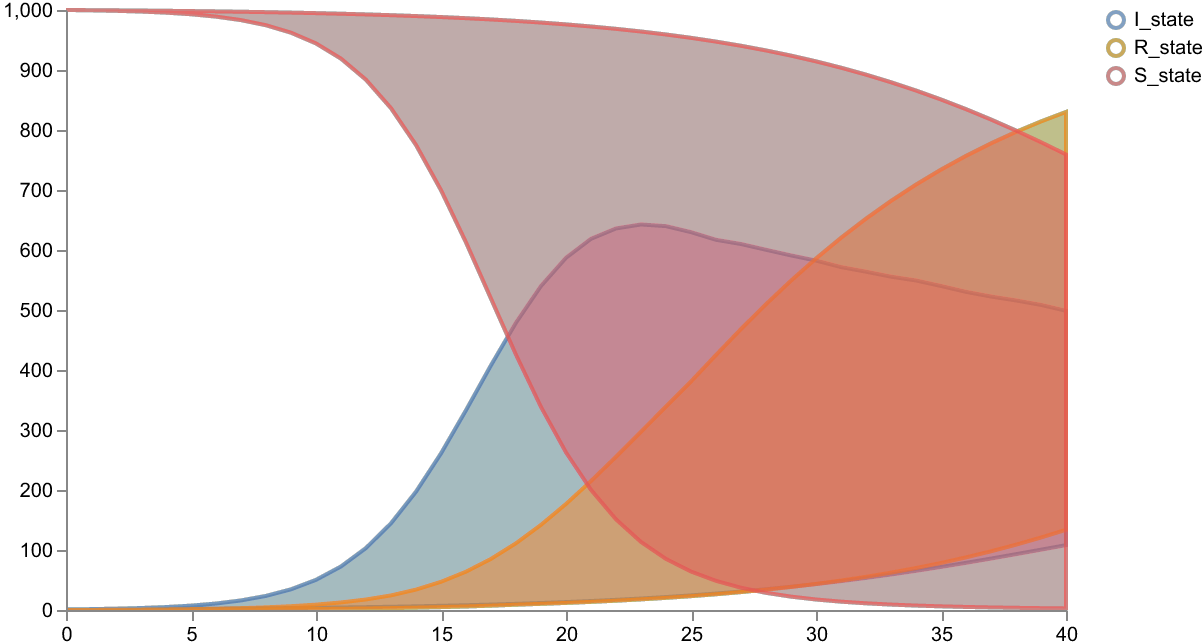

In [10]:
start_t = time.time()
sample_results1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results1["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Baseline samples before optimization from model 2 (SEIRHD)

Time taken:  4.139211416244507
Risk associated with QoI: [4464067.959999998]


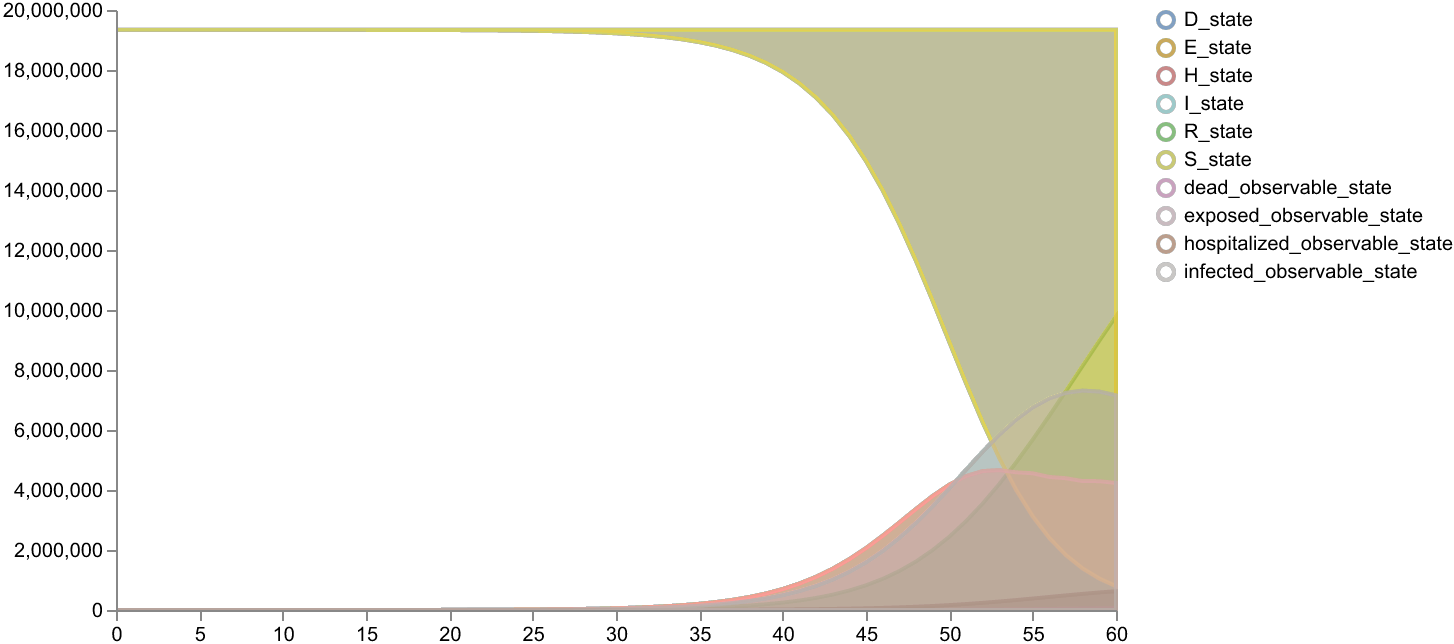

In [11]:
start_t = time.time()
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    num_samples,
    start_time=start_time,
    # solver_method="dopri5",
    solver_method="rk4",
    solver_options={"step_size": 1.}
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results2["risk"]["I_state"]["risk"])
# display(sample_results2["data"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with single intervention
### Optimizing a single parameter value (SIR)
Minimum change in the intervention parameter from the current value to get infections below 200 individuals at 40 days for SIR model

In [12]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

 52%|█████▏    | 62/120 [01:02<01:23,  1.44s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 54%|█████▍    | 65/120 [01:11<02:10,  2.37s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 56%|█████▌    | 67/120 [01:13<01:35,  1.80s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 60%|██████    | 72/120 [01:20<01:12,  1.51s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.

Optimal policy: tensor([0.1940], dtype=torch.float64)
{'policy': tensor([0.1940], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.15601673345676997
                          x: [ 1.940e-01]
                        nit: 3
      minimization_failures: 2
                       nfev: 74
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.15601673345676997
                                   x: [ 1.940e-01]
                                nfev: 7
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Intervention:  {1.0: {'p_cbeta': tensor([0.1940])}}


Risk associated with QoI: [217.07194946289061]


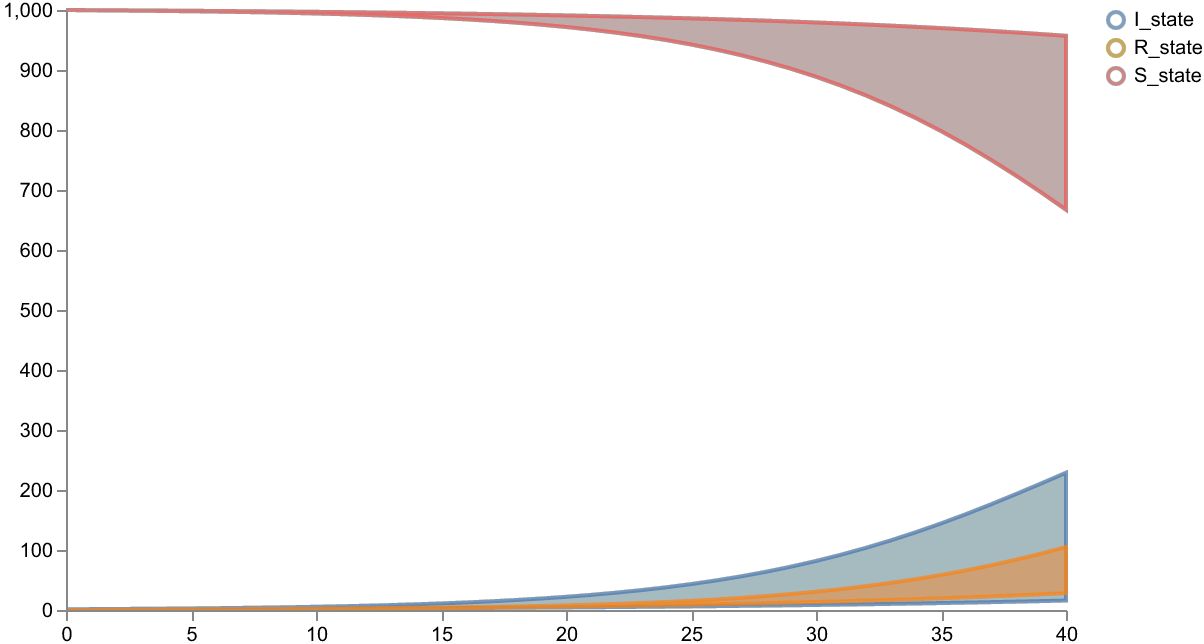

In [13]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))
result1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
# display(result1["data"])
print("Risk associated with QoI:", result1["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)


### Optimizing the start time for a single intervention (SIR)
Maximum delay in the intervention to get infections below 200 individuals at 40 days for SIR model

In [14]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 5.
bounds_interventions = [[1.], [39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

 36%|███▌      | 43/120 [00:48<01:26,  1.13s/it]

Optimal policy: tensor([7.6958], dtype=torch.float64)
{'policy': tensor([7.6958], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -7.69576122033028
                          x: [ 7.696e+00]
                        nit: 3
      minimization_failures: 0
                       nfev: 43
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -7.69576122033028
                                   x: [ 7.696e+00]
                                nfev: 10
                               maxcv: 9.765624980673238e-06}
Intervention:  {7.6958: {'p_cbeta': tensor([0.1500])}}


Risk associated with QoI: [154.71628662109373]


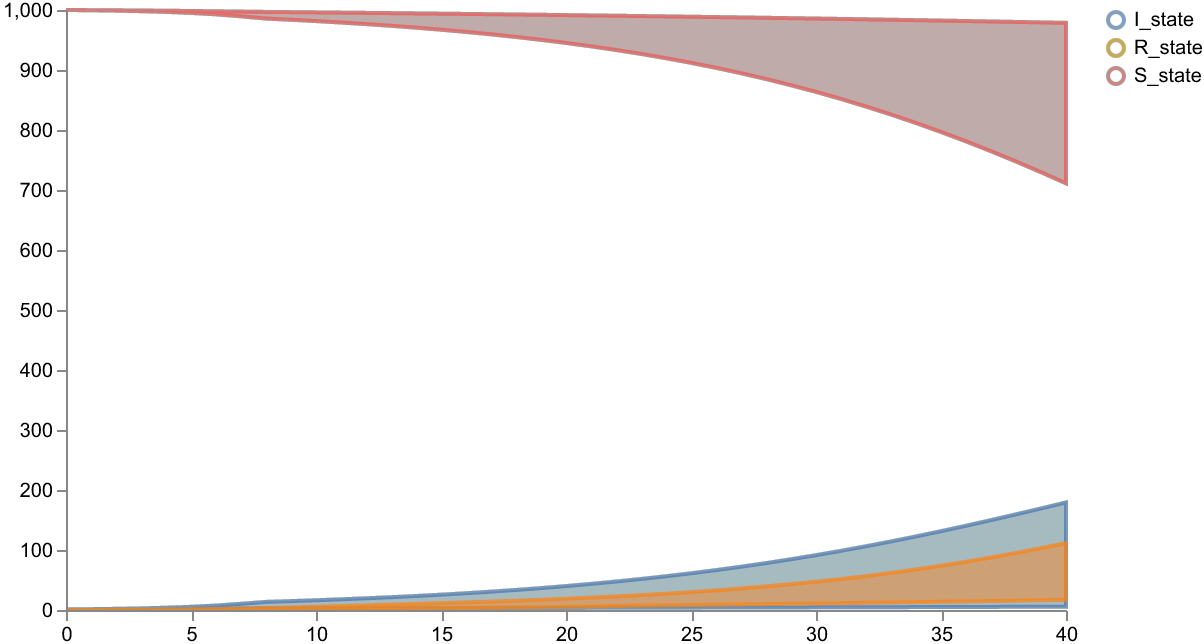

In [15]:
result2 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
    solver_options={"step_size": 1.},
)
# display(result2["data"])
# Check risk estimate used in constraints
print("Risk associated with QoI:", result2["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple interventions
### Optimizing multiple intervention values (SEIRHD)
Minimum change in two intervention parameters from their current values to get infections below 30000 individuals at 60 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

In [16]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.2, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass ina list of lambda x: torch.tensor(x) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 3e4
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.sum(np.abs(param_current - x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f"Optimal policy:", opt_result3["policy"])
print(opt_result3)

 53%|█████▎    | 64/120 [03:57<02:44,  2.94s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 79%|███████▉  | 95/120 [05:28<01:30,  3.63s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
124it [06:50,  3.31s/it]                         

Optimal policy: tensor([0.3500, 0.4495], dtype=torch.float64)
{'policy': tensor([0.3500, 0.4495], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.2494535138541334
                          x: [ 3.500e-01  4.495e-01]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: 0.2494535138541334
                                   x: [ 3.500e-01  4.494e-01]
                                nfev: 30
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Intervention:  {10.0: {'beta_c': tensor([0.3500])}, 15.0: {'gamma': tensor([0.4495])}}
Risk associated with QoI: [33007.13003906248]


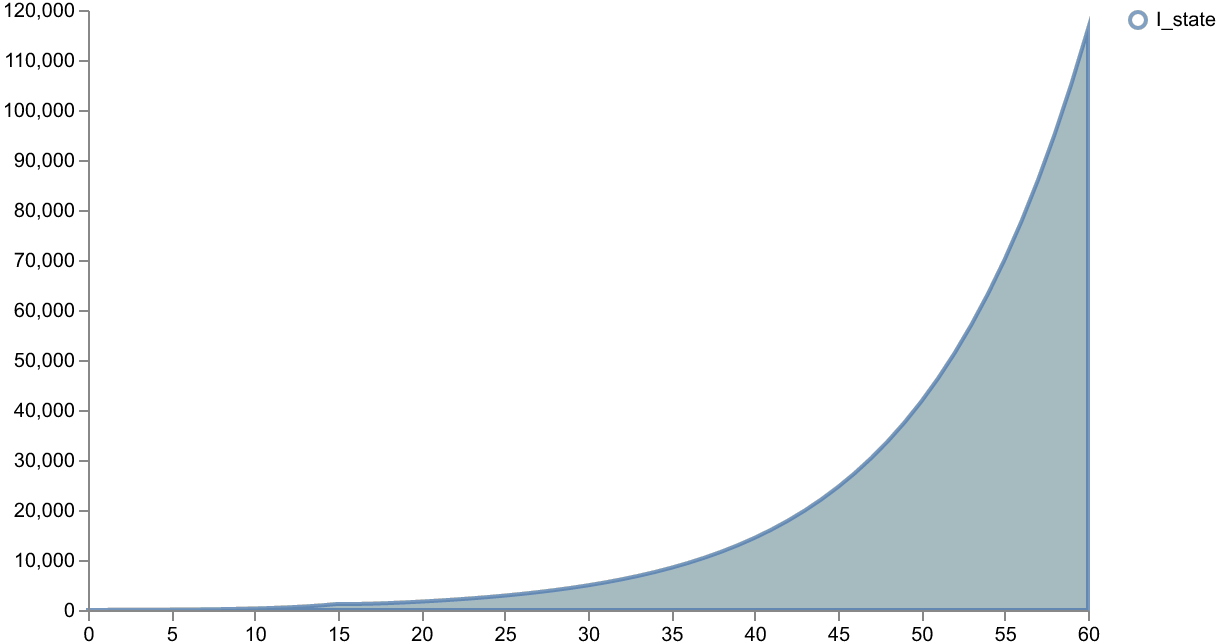

In [17]:
print("Intervention: ", static_parameter_interventions(opt_result3["policy"]))
with pyro.poutine.seed(rng_seed=0):
    result3 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result3["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Optimizing for start times of multiple interventions (SEIRHD)
Maximum delay in starting two interventions to get infections below 30000 individuals at 60 days for SEIRHD model
* Intervene on beta_c to be 0.15
* Intervene on gamma to be 0.4

In [18]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["beta_c", "gamma"]
initial_guess_interventions = [torch.tensor(10.), torch.tensor(10.)]
bounds_interventions = [[1., 1.], [39., 39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15, 0.4])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = [3e4]
qoi = [lambda y: obs_nday_average_qoi(y, observed_params, 1)]
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result4 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result4["policy"])
print(opt_result4)
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))

  8%|▊         | 9/120 [00:27<05:11,  2.81s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 10%|█         | 12/120 [00:32<04:09,  2.31s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 12%|█▎        | 15/120 [00:38<03:41,  2.11s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 14%|█▍        | 17/120 [00:40<03:08,  1.83s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 17%|█▋        | 20/120 [00:47<03:17,  1.98s/it]C:\Users\Anir

Optimal policy: tensor([39.0000,  6.0327], dtype=torch.float64)
{'policy': tensor([39.0000,  6.0327], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -45.032607877335636
                          x: [ 3.900e+01  6.033e+00]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: -45.032607877335636
                                   x: [ 3.900e+01  6.033e+00]
                                nfev: 30
                               maxcv: 0.006562499991559889}
Intervention:  {39.0: {'beta_c': tensor([0.1500])}, 6.0327: {'gamma': tensor([0.4000])}}


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\interfaces.py:978: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


Intervention:  {39.0: {'beta_c': tensor([0.1500])}, 6.0327: {'gamma': tensor([0.4000])}}
Time taken:  10.36467456817627
Risk associated with QoI: [33810.86929687499]


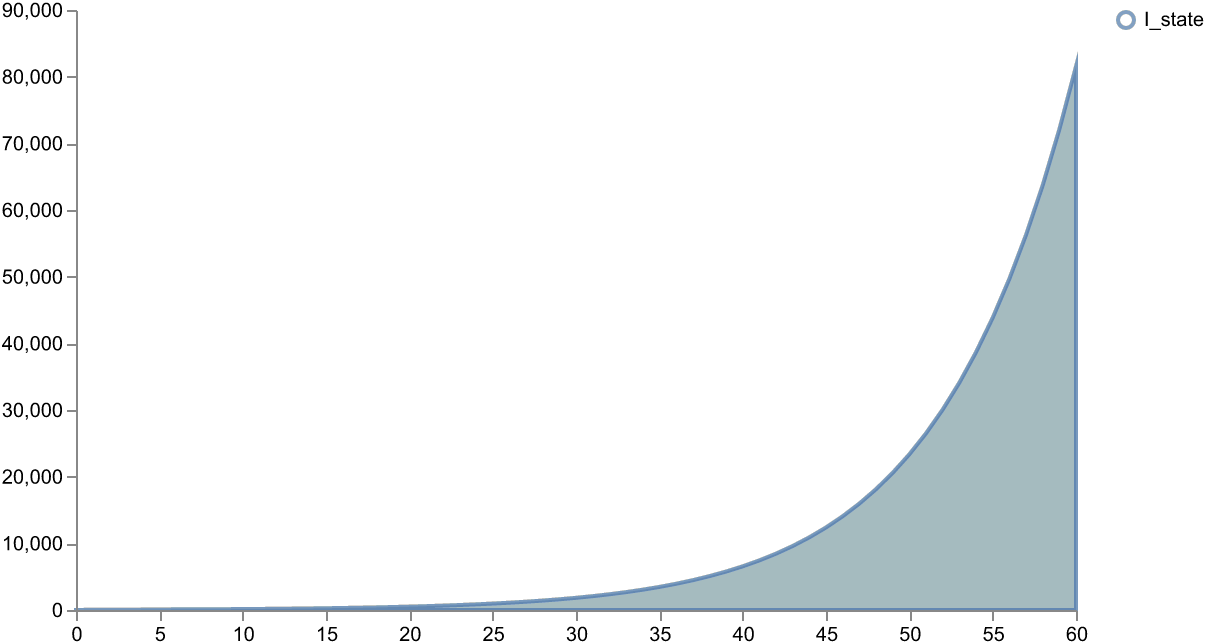

In [19]:
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="rk4",
        # solver_method="euler",
        solver_options={"step_size":1.},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple interventions and QoI defined as max over range of simulated time
### Optimizing multiple intervention values (SEIRHD) with existing intervention on hosp parameter
Minimum change in two intervention parameters from their current values to get infections below 300,000 individuals betweeen 0-90 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

Intervention on "hosp" parameter is set to 0.1 after 10 days

In [20]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.2, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass in a list of lambda x: torch.tensor(x) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 3e5
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: np.sum(np.abs(param_current - x))
fixed_interventions = {torch.tensor(10.0): {"hosp": torch.tensor(0.1)}}

# Run optimize interface
opt_result5 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD2,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    fixed_static_parameter_interventions=fixed_interventions,
    solver_method="rk4",
    solver_options={"step_size": 1.0},
)
print(f"Optimal policy:", opt_result5["policy"])
print(opt_result5)

 28%|██▊       | 33/120 [02:39<06:09,  4.25s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 52%|█████▎    | 63/120 [04:37<04:14,  4.46s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 79%|███████▉  | 95/120 [06:38<01:46,  4.25s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
124it [08:25,  4.08s/it]                         

Optimal policy: tensor([0.3500, 0.4602], dtype=torch.float64)
{'policy': tensor([0.3500, 0.4602], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.26016707274061507
                          x: [ 3.500e-01  4.602e-01]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: 0.26016707274061507
                                   x: [ 3.500e-01  4.601e-01]
                                nfev: 30
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Fixed interventions:  {10.0: {'hosp': tensor(0.1000)}}
Optimal intervention (including fixed interventions):  {10.0: {'hosp': tensor(0.1000), 'beta_c': tensor([0.3500])}, 15.0: {'gamma': tensor([0.4602])}}
Risk associated with QoI: [306010.22749999986]


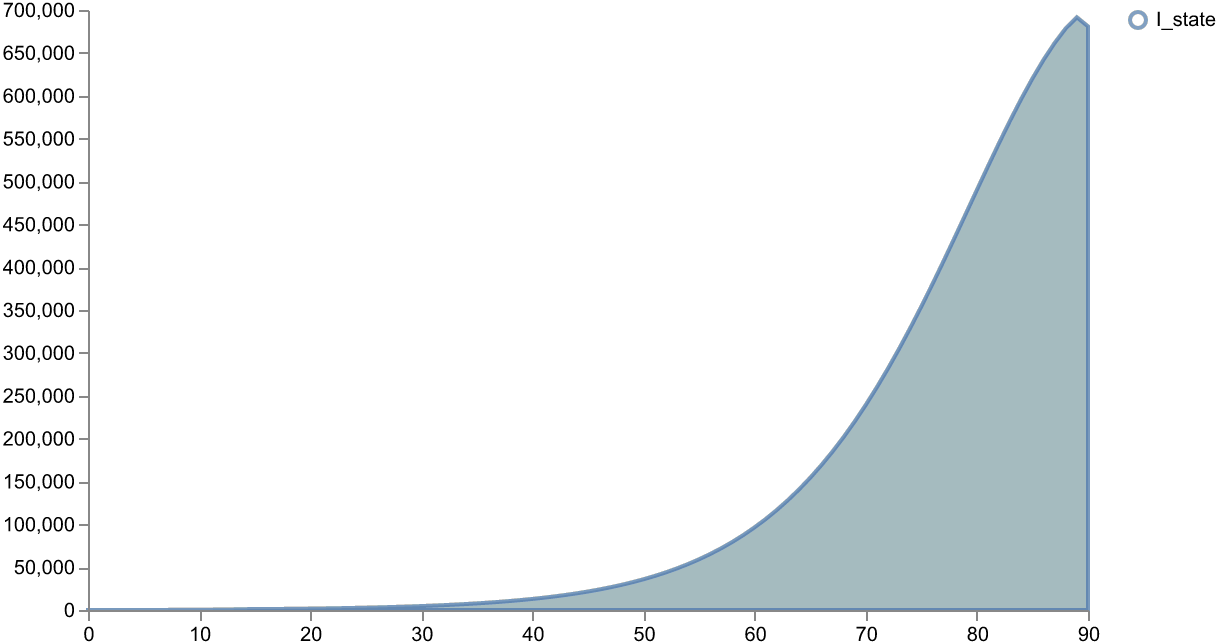

In [21]:
print("Fixed interventions: ", fixed_interventions)
opt_intervention = combine_static_parameter_interventions([deepcopy(fixed_interventions), static_parameter_interventions(opt_result5["policy"])])
print("Optimal intervention (including fixed interventions): ", opt_intervention)
with pyro.poutine.seed(rng_seed=0):
    result5 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD2,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=opt_intervention,
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result5["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result5["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple intervention templates
### Optimizing multiple intervention values and/or start times with existing intervention on hosp parameter (SEIRHD)
Get infections below 300,000 individuals betweeen 0-90 days for SEIRHD model
* Minimum change from their current value when intervening on beta_c after 10 days
* Maximum delay in starting the interventions on gamma with intervention value set to 0.35

Intervention on "hosp" parameter is set to 0.1 after 10 days.

QoI defined as max over range of simulated time.

In [22]:
intervened_params = ["beta_c", "gamma", "gamma_c"]
static_parameter_interventions1 = param_value_objective(
    param_name=[intervened_params[0]],
    start_time=[torch.tensor(10.0)],
)
static_parameter_interventions2 = start_time_objective(
    param_name=[intervened_params[1]],
    param_value=[torch.tensor([0.4])],
)

# Combine different intervention templates
static_parameter_interventions_comb = intervention_func_combinator(
    [static_parameter_interventions1, static_parameter_interventions2],
    [1, 1],
)

print(
    static_parameter_interventions1(torch.tensor(0.4)),
    static_parameter_interventions2(torch.tensor(5.0)),
)
print(static_parameter_interventions_comb(torch.tensor([0.3, 5.0])))

{10.0: {'beta_c': tensor([0.4000])}} {5.0: {'gamma': tensor([0.4000])}}
{10.0: {'beta_c': tensor([0.3000])}, 5.0: {'gamma': tensor([0.4000])}}


In [23]:
# Define optimization problem setup
observed_params = ["I_state"]
risk_bound = 3e5
qoi = lambda y: obs_max_qoi(y, observed_params)
initial_guess_interventions = [0.35, 5.0]
bounds_interventions = [[0.1, 1.0], [0.5, end_time_SEIRHD2]]

# Objective function
beta_c_current = 0.35
# Scaling factors for start time and parameter values in the objective function
scaling_factor_obj = [1.0, 0.4 / (end_time_SEIRHD2 - start_time)]
objfun = (
    lambda x: np.abs(beta_c_current - x[0]) * scaling_factor_obj[0]
    - x[1] * scaling_factor_obj[1]
)

# Creating a combined intervention
intervened_params = ["beta_c", "gamma"]
static_parameter_interventions1 = param_value_objective(
    param_name=[intervened_params[0]],
    start_time=[torch.tensor(10.0)],
)
static_parameter_interventions2 = start_time_objective(
    param_name=[intervened_params[1]],
    param_value=[torch.tensor([0.45])],
)
# Combine different intervention templates into a list of Callables
static_parameter_interventions = intervention_func_combinator(
    [static_parameter_interventions1, static_parameter_interventions2],
    [1, 1],
)

# Fixed intervention on hosp parameter
fixed_interventions = {torch.tensor(10.0): {"hosp": torch.tensor(0.1)}}

# Run optimize interface
opt_result6 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD2,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    fixed_static_parameter_interventions=fixed_interventions,
    solver_method="rk4",
    solver_options={"step_size": 1.0},
)
print(f"Optimal policy:", opt_result6["policy"])
print(opt_result6)

  1%|          | 1/120 [00:07<14:21,  7.24s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  2%|▎         | 3/120 [00:11<06:28,  3.32s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  5%|▌         | 6/120 [00:15<03:58,  2.10s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out

Optimal policy: tensor([ 0.1998, 12.1812], dtype=torch.float64)
{'policy': tensor([ 0.1998, 12.1812], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.09606939020723225
                          x: [ 1.998e-01  1.218e+01]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: 0.09606939020723225
                                   x: [ 1.998e-01  1.218e+01]
                                nfev: 30
                               maxcv: 1949.409374999872}



C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\interfaces.py:978: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


#### Sample using optimal policy as intervention

Fixed interventions:  {10.0: {'hosp': tensor(0.1000)}}
Optimal intervention (including fixed interventions):  {10.0: {'hosp': tensor(0.1000), 'beta_c': tensor([0.1998])}, 12.1812: {'gamma': tensor([0.4500])}}
Risk associated with QoI: [308213.24624999985]


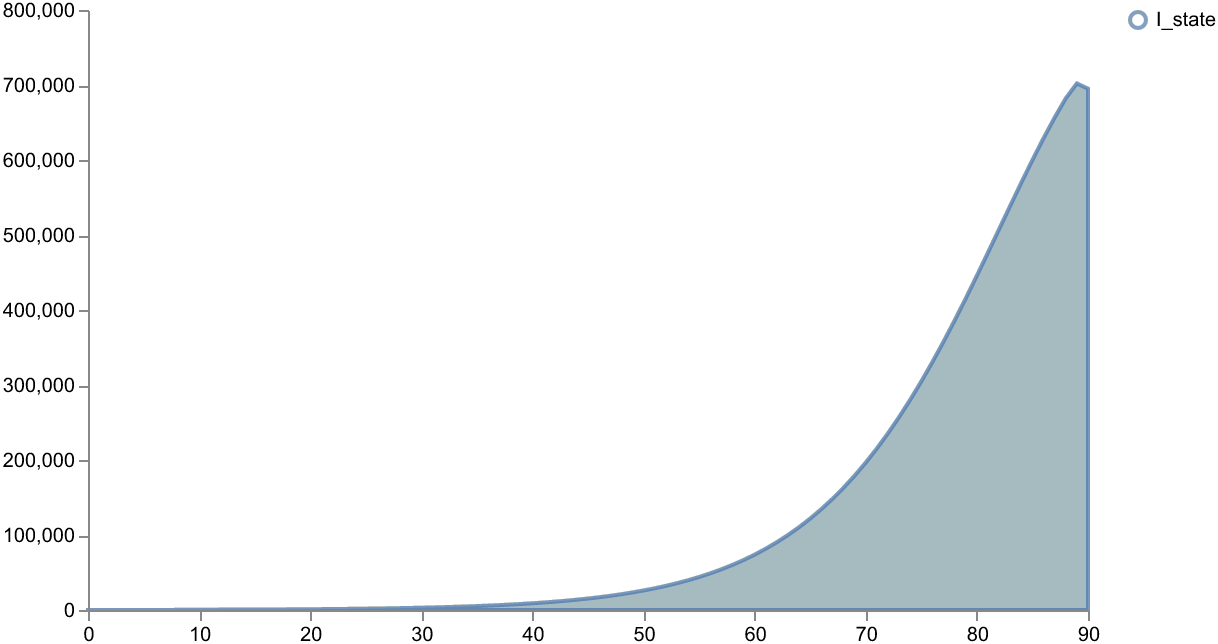

In [24]:
print("Fixed interventions: ", fixed_interventions)
intervention_list = [deepcopy(fixed_interventions)]
intervention_list.extend([static_parameter_interventions(opt_result6["policy"])])
opt_intervention = combine_static_parameter_interventions(intervention_list)
print("Optimal intervention (including fixed interventions): ", opt_intervention)
with pyro.poutine.seed(rng_seed=0):
    result6 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD2,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=opt_intervention,
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result6["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result6["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple constraints
### Optimizing multiple intervention values and/or start times with multiple constraints for different QoIs with existing intervention on hosp parameter (SEIRHD)
Get infections below 300,000 individuals (risk level 95\%) and hospitalization below 100,000 individuals (risk level 90\%) betweeen 0-90 days for SEIRHD model
* Minimum change from their current value when intervening on beta_c after 10 days
* Maximum delay in starting the interventions on gamma with intervention value set to 0.35

Intervention on "hosp" parameter is set to 0.1 after 10 days.

QoI defined as max over range of simulated time.

In [25]:
# Define optimization problem setup
observed_params = [["I_state"], ["H_state"]]
risk_bound = [3e5, 1e5]
alpha = [0.95, 0.90]
qoi = [lambda y: obs_max_qoi(y, observed_params[0]), lambda y: obs_max_qoi(y, observed_params[1])]
initial_guess_interventions = [0.35, 5.0]
bounds_interventions = [[0.1, 1.0], [0.5, end_time_SEIRHD2]]

# Objective function
beta_c_current = 0.35
# Scaling factors for start time and parameter values in the objective function
scaling_factor_obj = [1.0, 0.4 / (end_time_SEIRHD2 - start_time)]
objfun = (
    lambda x: np.abs(beta_c_current - x[0]) * scaling_factor_obj[0]
    - x[1] * scaling_factor_obj[1]
)

# Creating a combined intervention
intervened_params = ["beta_c", "gamma"]
static_parameter_interventions1 = param_value_objective(
    param_name=[intervened_params[0]],
    start_time=[torch.tensor(10.0)],
)
static_parameter_interventions2 = start_time_objective(
    param_name=[intervened_params[1]],
    param_value=[torch.tensor([0.45])],
)
# Combine different intervention templates into a list of Callables
static_parameter_interventions = intervention_func_combinator(
    [static_parameter_interventions1, static_parameter_interventions2],
    [1, 1],
)

# Fixed intervention on hosp parameter
fixed_interventions = {torch.tensor(10.0): {"hosp": torch.tensor(0.1)}}

# Run optimize interface
opt_result6 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD2,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    fixed_static_parameter_interventions=fixed_interventions,
    alpha=alpha,
    solver_method="rk4",
    solver_options={"step_size": 1.0},
)
print(f"Optimal policy:", opt_result6["policy"])
print(opt_result6)

  1%|          | 1/120 [00:07<15:18,  7.72s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  2%|▎         | 3/120 [00:12<07:01,  3.61s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 27%|██▋       | 32/120 [02:01<05:50,  3.98s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:106: UserWarning: Selected interventions are ou

Optimal policy: tensor([ 0.3500, 13.9001], dtype=torch.float64)
{'policy': tensor([ 0.3500, 13.9001], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -0.06177817727638459
                          x: [ 3.500e-01  1.390e+01]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -0.06177817727638459
                                   x: [ 3.500e-01  1.390e+01]
                                nfev: 30
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Fixed interventions:  {10.0: {'hosp': tensor(0.1000)}}
Optimal intervention (including fixed interventions):  {10.0: {'hosp': tensor(0.1000), 'beta_c': tensor([0.3500])}, 13.9001: {'gamma': tensor([0.4500])}}
Risk associated with QoI I_state [352714.2268749998]
Risk associated with QoI H_state [61172.588671874975]


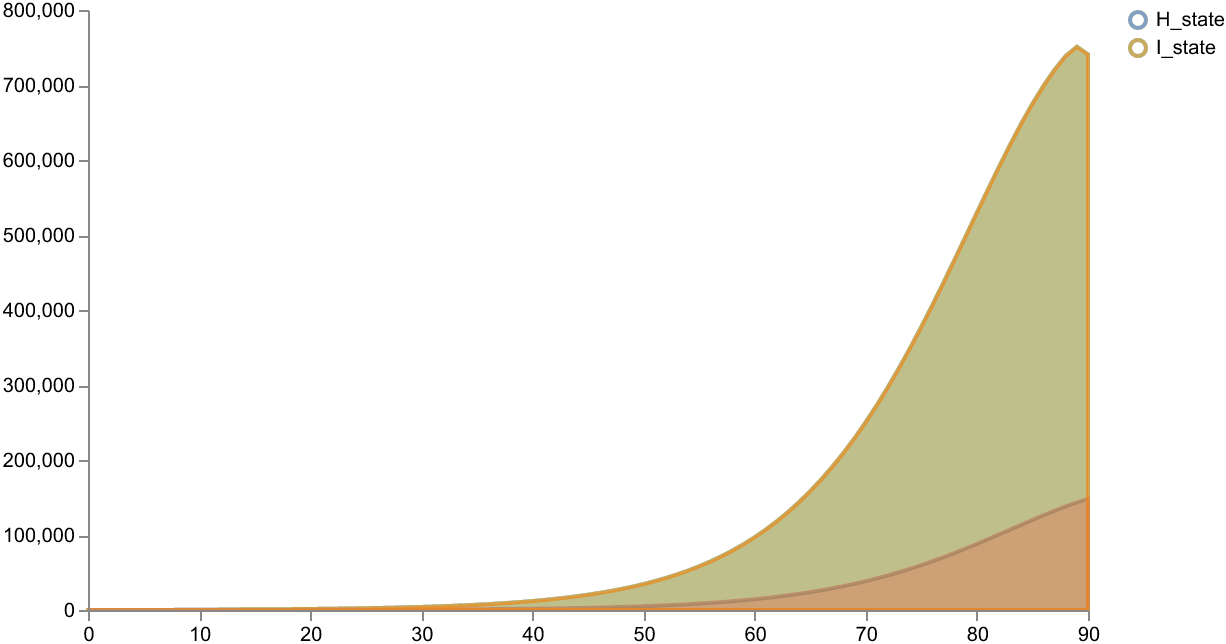

In [26]:
print("Fixed interventions: ", fixed_interventions)
intervention_list = [deepcopy(fixed_interventions)]
intervention_list.extend([static_parameter_interventions(opt_result6["policy"])])
opt_intervention = combine_static_parameter_interventions(intervention_list)
print("Optimal intervention (including fixed interventions): ", opt_intervention)
with pyro.poutine.seed(rng_seed=0):
    result6 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD2,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=opt_intervention,
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI", observed_params[0][0], result6["risk"][observed_params[0][0]]["risk"])
print("Risk associated with QoI", observed_params[1][0], result6["risk"][observed_params[1][0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result6["data"], keep=["I_state", "H_state"], qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)